In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config import GOOGLE_PATH, WEATHER_PATH, POP_PATH, FLU_PATH
import json
from datetime import datetime

In [3]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [4]:
flu.columns

Index(['valueCategory', 'temporal', 'temporal_type', 'georegion',
       'georegion_type', 'agegroup', 'agegroup_type', 'sex', 'value',
       'popExtrapolation', 'totalConsultationsExtrapolation', 'incValue',
       'prctConsultations', 'prct', 'trend', 'dataComplete'],
      dtype='object')

In [5]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue', 'value']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [6]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [7]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [8]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [9]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [10]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [11]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'value', 'region_x',
       'date', 'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [12]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [13]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [14]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [15]:
# merged_data.set_index('date', inplace=True)

In [16]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

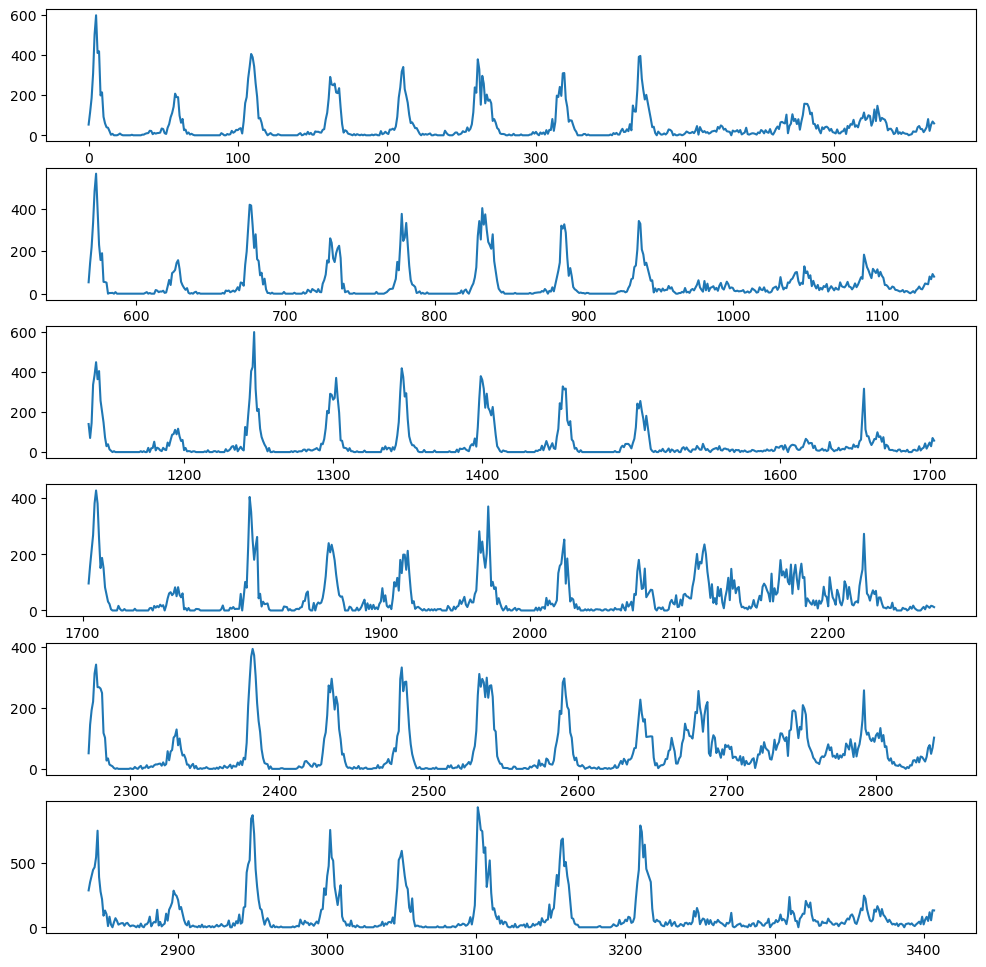

In [17]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])

<h3>Feature Engineering</h3>

In [18]:
def time_series_cross_validation(model, X, y, n_splits=5):
    scores = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        
        predictions = autoregressive_iterative_forecast(cloned_model, X_train[-1], len(y_val))
        
        score = mean_squared_error(y_val, predictions, squared=False)
        scores.append(score)
    
    return np.mean(scores)

In [19]:
from sklearn.model_selection import TimeSeriesSplit

# Example data
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [113]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [21]:
def autoregressive_iterative_forecast(model, initial_input, n_steps):
    """
    Perform iterative forecasting using an autoregressive model.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features (e.g., the last observation from the training set).
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    current_input = initial_input.copy()
    forecasts = []

    for _ in range(n_steps):
        # Predict the next step
        next_step_pred = model.predict(current_input.reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update the current input to include the new prediction
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_step_pred

    return np.array(forecasts)

def create_lagged_features(df, column, number_of_lags=4, seasonal=52):
    
    # Group by 'georegion' and apply the lagging within each group
    new_df = df.groupby('georegion', group_keys=False).apply(lambda group: group.assign(
        **{f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)},
        **{f'seasonal_lag_{seasonal}': group[column].shift(seasonal)}
    ))

    # Reset index to flatten the dataframe structure after grouping
    new_df.reset_index(drop=True, inplace=True)

    return new_df




In [22]:
def create_lagged_features(df, column, number_of_lags=4, seasonal_lags=[52]):
    # Define a helper function to apply within each group
    def add_lags(group):
        # Create a dictionary for the lagged features
        lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
        for seasonal_lag in seasonal_lags:
            lags.update({f'seasonal_lag_{i}': group[column].shift(i) for i in range(seasonal_lag - 2, seasonal_lag + 3)})
        # Return the original column along with the lagged features
        return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

    # Group by 'georegion' and apply the lagging within each group
    new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

    # Reset index to flatten the dataframe structure after grouping
    new_df.reset_index(drop=True, inplace=True)

    return new_df


data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

df_lagged = create_lagged_features(data, column='incValue')
df_lagged.dropna(inplace=True)
training_cols = [col for col in df_lagged.columns if 'lag_' in col]
X = df_lagged[training_cols]
y = df_lagged['incValue']

In [23]:
# def create_lagged_features(df, column, seasonal_lags=[52, 104], intermediate_lags=[4, 8, 12]):
#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(lambda group: group.assign(
#         **{f'intermediate_lag_{i}': group[column].shift(i) for i in intermediate_lags},
#         **{f'seasonal_lag_{i}': group[column].shift(i) for i in seasonal_lags}
#     ))

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df

# Initialize the list of lag combinations with the base lags
# lag_combinations = [[1, 2, 3]]
# # Create an expanding window of lags
# for lag in range(4, 48 + 1, 4):
#     # Add the current 4-week lag to the last list in the combinations
#     new_lags = lag_combinations[-1] + [lag]
#     lag_combinations.append(new_lags)

In [163]:
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# Define parameter configurations to assess
lags = 51 # Autoregressive lags to consider
hidden_layer_sizes = [(32,), (32, 32)]
alphas = [0.0001, 0.001, 0.01] # Regularization parameter
batch_sizes = [32]
learning_rates = [0.001, 0.01]
activations = ['relu']
seasonal = [[52]]

models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# Grid search hyperparameter configurations
for lag in range(30, lags):
    for seasonal_lags in seasonal:
        # Create lagged features
        df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
        df_lagged.dropna(inplace=True)
        training_cols = [col for col in df_lagged.columns if 'lag_' in col]
        X = df_lagged[training_cols]
        y = df_lagged['incValue']

        # Split the data
        split = int(len(y) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Scale the inputs
        scaler_X = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

        # Scale the target
        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

        # Keep track of configurations and cv scores

        for hidden_layers in hidden_layer_sizes:
            for learning_rate in learning_rates:
                for activation in activations:
                    for alpha in alphas:
                        for batch_size in batch_sizes:
                            model = MLPRegressor(max_iter=1000, 
                                                random_state=42, 
                                                solver='adam', 
                                                activation=activation, 
                                                hidden_layer_sizes=hidden_layers, 
                                                alpha=alpha, 
                                                batch_size=batch_size, 
                                                learning_rate_init=learning_rate,
                                                early_stopping=True, 
                                                validation_fraction=0.1, 
                                                n_iter_no_change=100,
                                                tol=1e-3)
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=3)
                            for train_index, val_index in tscv.split(X_train):
                                # Create rolling windows
                                X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
                                y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                                
                                # Fit model
                                model.fit(X_train_cv, y_train_cv)
                                
                                predictions = autoregressive_iterative_forecast(model, X_train_cv[-1], len(y_val))
                                
                                rmse = mean_squared_error(y_val, predictions, squared=False)
                                scores.append(rmse)
                            
                            # Fill in parameters and score for each configuration 
                            scores_df.loc[i, 'lags'] = lag
                            scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
                            scores_df.loc[i, 'hidden_layers'] = hidden_layers
                            scores_df.loc[i, 'alpha'] = alpha
                            scores_df.loc[i, 'batch_size'] = batch_size
                            scores_df.loc[i, 'activation'] = activation
                            scores_df.loc[i, 'learning_rate'] = learning_rate
                            scores_df.loc[i, 'RMSE'] = np.mean(scores)
                            print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
                            i += 1

0/378: 0.00%
1/378: 0.26%
2/378: 0.53%
3/378: 0.79%
4/378: 1.06%
5/378: 1.32%
6/378: 1.59%
7/378: 1.85%
8/378: 2.12%
9/378: 2.38%
10/378: 2.65%
11/378: 2.91%
12/378: 3.17%
13/378: 3.44%
14/378: 3.70%
15/378: 3.97%
16/378: 4.23%
17/378: 4.50%
18/378: 4.76%
19/378: 5.03%
20/378: 5.29%
21/378: 5.56%
22/378: 5.82%
23/378: 6.08%
24/378: 6.35%
25/378: 6.61%
26/378: 6.88%
27/378: 7.14%
28/378: 7.41%
29/378: 7.67%
30/378: 7.94%
31/378: 8.20%
32/378: 8.47%
33/378: 8.73%
34/378: 8.99%
35/378: 9.26%
36/378: 9.52%
37/378: 9.79%
38/378: 10.05%
39/378: 10.32%
40/378: 10.58%
41/378: 10.85%
42/378: 11.11%
43/378: 11.38%
44/378: 11.64%
45/378: 11.90%
46/378: 12.17%
47/378: 12.43%
48/378: 12.70%
49/378: 12.96%
50/378: 13.23%
51/378: 13.49%
52/378: 13.76%
53/378: 14.02%
54/378: 14.29%
55/378: 14.55%
56/378: 14.81%
57/378: 15.08%
58/378: 15.34%
59/378: 15.61%
60/378: 15.87%
61/378: 16.14%
62/378: 16.40%
63/378: 16.67%
64/378: 16.93%
65/378: 17.20%
66/378: 17.46%
67/378: 17.72%
68/378: 17.99%
69/378: 18.25

In [213]:
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# Define parameter configurations to assess
lags = 51 # Autoregressive lags to consider
hidden_layer_sizes = [(32,), (32, 32)]
alphas = [0.0001, 0.001, 0.01] # Regularization parameter
batch_sizes = [32]
learning_rates = [0.001, 0.01]
activations = ['relu']
seasonal = [[52]]

models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# Grid search hyperparameter configurations
for lag in range(30, lags):
    for seasonal_lags in seasonal:
        # Create lagged features
        df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
        df_lagged.dropna(inplace=True)
        training_cols = [col for col in df_lagged.columns if 'lag_' in col]
        X = df_lagged[training_cols]
        y = df_lagged['incValue']

        # Split the data
        split = int(len(y) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Scale the inputs
        scaler_X = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

        # Scale the target
        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

        # Keep track of configurations and cv scores

        for hidden_layers in hidden_layer_sizes:
            for learning_rate in learning_rates:
                for activation in activations:
                    for alpha in alphas:
                        for batch_size in batch_sizes:
                            model = MLPRegressor(max_iter=1000, 
                                                random_state=42, 
                                                solver='adam', 
                                                activation=activation, 
                                                hidden_layer_sizes=hidden_layers, 
                                                alpha=alpha, 
                                                batch_size=batch_size, 
                                                learning_rate_init=learning_rate,
                                                early_stopping=True, 
                                                validation_fraction=0.1, 
                                                n_iter_no_change=100,
                                                tol=1e-3)
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=3)
                            for train_index, val_index in tscv.split(X_train):
                                # Create rolling windows
                                X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
                                y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                                
                                # Fit model
                                model.fit(X_train_cv, y_train_cv)
                                predictions = []
                                for t in range(len(y_val)):
                                    one_step_prediction = autoregressive_iterative_forecast(model, X_train_cv[-1] if t == 0 else X_val[t-1], 1)
                                    predictions.append(one_step_prediction)
                                
                                rmse = mean_squared_error(y_val, predictions, squared=False)
                                scores.append(rmse)
                            
                            # Fill in parameters and score for each configuration 
                            scores_df.loc[i, 'lags'] = lag
                            scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
                            scores_df.loc[i, 'hidden_layers'] = hidden_layers
                            scores_df.loc[i, 'alpha'] = alpha
                            scores_df.loc[i, 'batch_size'] = batch_size
                            scores_df.loc[i, 'activation'] = activation
                            scores_df.loc[i, 'learning_rate'] = learning_rate
                            scores_df.loc[i, 'RMSE'] = np.mean(scores)
                            print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
                            i += 1

0/252: 0.00%
1/252: 0.40%
2/252: 0.79%
3/252: 1.19%
4/252: 1.59%
5/252: 1.98%
6/252: 2.38%
7/252: 2.78%
8/252: 3.17%
9/252: 3.57%
10/252: 3.97%
11/252: 4.37%
12/252: 4.76%
13/252: 5.16%
14/252: 5.56%
15/252: 5.95%
16/252: 6.35%
17/252: 6.75%
18/252: 7.14%
19/252: 7.54%
20/252: 7.94%
21/252: 8.33%
22/252: 8.73%
23/252: 9.13%
24/252: 9.52%
25/252: 9.92%
26/252: 10.32%
27/252: 10.71%
28/252: 11.11%
29/252: 11.51%
30/252: 11.90%
31/252: 12.30%
32/252: 12.70%
33/252: 13.10%
34/252: 13.49%
35/252: 13.89%
36/252: 14.29%
37/252: 14.68%
38/252: 15.08%
39/252: 15.48%
40/252: 15.87%
41/252: 16.27%
42/252: 16.67%
43/252: 17.06%
44/252: 17.46%
45/252: 17.86%
46/252: 18.25%
47/252: 18.65%
48/252: 19.05%
49/252: 19.44%
50/252: 19.84%
51/252: 20.24%
52/252: 20.63%
53/252: 21.03%
54/252: 21.43%
55/252: 21.83%
56/252: 22.22%
57/252: 22.62%
58/252: 23.02%
59/252: 23.41%
60/252: 23.81%
61/252: 24.21%
62/252: 24.60%
63/252: 25.00%
64/252: 25.40%
65/252: 25.79%
66/252: 26.19%
67/252: 26.59%
68/252: 26.98%
6

In [214]:
scores_df['RMSE'] = pd.to_numeric(scores_df['RMSE'])
# Best parameters and score
best_config_index = scores_df['RMSE'].idxmin()  # This gets the index of the minimum RMSE
best_config = scores_df.loc[best_config_index]  # Use the index to access the row
best_score = best_config['RMSE']
print(f"Best parameters: {best_config}")
print(f"Best score (RMSE): {best_score}")

Best parameters: RMSE             0.11663
lags                  30
seasonal_lags       [52]
hidden_layers      (32,)
alpha               0.01
batch_size            32
activation          relu
learning_rate       0.01
Name: 5, dtype: object
Best score (RMSE): 0.11663031341021413


In [215]:
scores_df.sort_values(by='RMSE').head(60)

,RMSE,lags,seasonal_lags,hidden_layers,alpha,batch_size,activation,learning_rate
125,0.116630,40,[52],"(32,)",0.01,32,relu,0.01
53,0.116630,34,[52],"(32,)",0.01,32,relu,0.01
65,0.116630,35,[52],"(32,)",0.01,32,relu,0.01
77,0.116630,36,[52],"(32,)",0.01,32,relu,0.01
29,0.116630,32,[52],"(32,)",0.01,32,relu,0.01
89,0.116630,37,[52],"(32,)",0.01,32,relu,0.01
101,0.116630,38,[52],"(32,)",0.01,32,relu,0.01
113,0.116630,39,[52],"(32,)",0.01,32,relu,0.01
137,0.116630,41,[52],"(32,)",0.01,32,relu,0.01
149,0.116630,42,[52],"(32,)",0.01,32,relu,0.01


In [223]:
best_config = scores_df.loc[239]

In [224]:
best_lag = best_config.values[1]
best_seasonal_lag = best_config.values[2]
best_hidden_layers = best_config.values[3]
best_alpha = best_config.values[4]
best_batch_size = best_config.values[5]
best_activation = best_config.values[6]
best_learning_rate = best_config.values[7]

In [225]:
# Create lagged features
df_lagged = create_lagged_features(data, column='incValue', number_of_lags=best_lag, seasonal_lags=best_seasonal_lag)
df_lagged.dropna(inplace=True)
training_cols = [col for col in df_lagged.columns if 'lag_' in col]
X = df_lagged[training_cols]
y = df_lagged['incValue']

# Split the data
split = int(len(y) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale the inputs
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

# Train the final model
final_model = MLPRegressor(max_iter=1000, 
                    random_state=42, 
                    solver='adam', 
                    activation=best_activation, 
                    hidden_layer_sizes=best_hidden_layers, 
                    alpha=best_alpha, 
                    batch_size=best_batch_size, 
                    learning_rate_init=best_learning_rate,
                    tol=1e-3)
final_model.fit(X_train_scaled, y_train_scaled)  # Ensure y_train_scaled is flattened
# Get the last observation from the training set as the initial input for forecasting
initial_input = X_train_scaled[-1]

# Forecast for the length of the test set
forecasts = autoregressive_iterative_forecast(final_model, initial_input, len(y_test))
y_hat_train = autoregressive_iterative_forecast(final_model, X_train_scaled[0], len(y_train))


forecasts = scaler_y.inverse_transform(forecasts.reshape(-1, 1))
y_hat_train = scaler_y.inverse_transform(y_hat_train.reshape(-1, 1))
# Evaluate the forecasts against the actual y_test values
rmse = mean_squared_error(y_test, forecasts, squared=False)

print(f"The RMSE for the forecasts is: {rmse:.3f}")

The RMSE for the forecasts is: 131.852


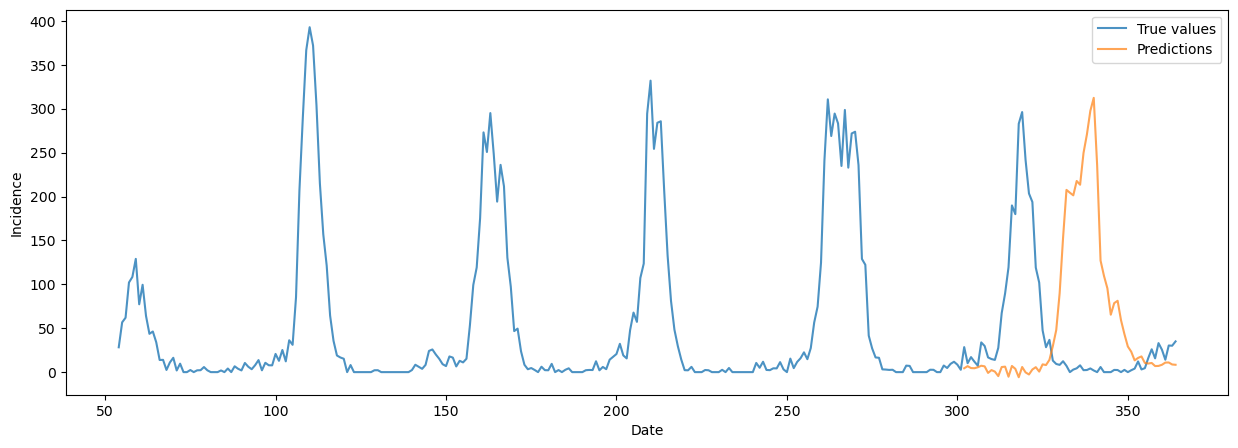

In [226]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the true values
ax.plot(df_lagged['incValue'], label="True values", alpha=0.8)
ax.plot(y_test.index, forecasts, label='Predictions', alpha=0.7)
# Plot the predictions

# Add labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
ax.legend()

<h3>Exogenous Variables</h3>